In [1]:
#IMPORT LIBRARIES
import sqlite3
import os
import pandas as pd
import numpy as np
import random
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from itertools import product
from math import ceil
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline
#from pandas_profiling import ProfileReport 
%config InlineBackend.figure_format = 'retina' 
from scipy.stats import iqr as IQR
from collections import Counter
import scipy.stats as stat
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

from sklearn.metrics import roc_curve, auc
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set()

Collect initial data

In [2]:
#import file csv
df = pd.read_csv('retail.csv')
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

### Describe, explore and assess data quality

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.replace("", np.nan, inplace=True)

In [7]:
# Summary statistics for all variables
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Function to show missing values and their percentages
def missing_data(df):
    l = []
    for col in df.columns:
        missing = df[col].isnull().sum(axis=0)
        percentage = missing/df.shape[0]
        l.append([col,missing,percentage*100])
        df_missing = pd.DataFrame(l, columns = ['Feature','missing','percentage'])
        df_missing = df_missing.sort_values('missing',axis=0, ascending = False)    
    return df_missing

In [9]:
df_missing = missing_data(df)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,135080,24.926694
2,Description,1454,0.268311


In [10]:
# Check duplicated observations
df.loc[df.duplicated(keep=False), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [11]:
# Create a dataframe copy
df1 = df.copy()

## Data Preparation

### Clean data

In [12]:
# Dropduplicated rows
df1.drop_duplicates(inplace=True)

In [13]:
# Select irregular stock code values
irregular_stockcode = ['DCGS0076','DCGS0003','DCGS0070','DCGS0055', 'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057',
                       'DCGSSBOY', 'DCGSSGIRL', 'DCGS0004', 'DCGS0073', 'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P',
                       'POST', 'D', 'DOT','M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'gift_0001_40', 'gift_0001_50', 
                       'gift_0001_30', 'gift_0001_20','gift_0001_10', 'PADS', 'B', 'CRUK', 'c2','C2','m']

In [14]:
# Remove records with irregular stock code values
df1 = df1[~  df1['StockCode'].isin(irregular_stockcode)]

In [15]:
#Remove transactions with price =0.  
df1 = df1[df1['UnitPrice']>0]

In [16]:
print('Percentage of data kept after removing irregularities:', np.round(df1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing irregularities: 0.9802


In [17]:
# 'Unspecified' will be kept because it does not affect the collaborative filtering algorithm
df1['Country'].value_counts()

United Kingdom          486167
Germany                   9080
France                    8218
EIRE                      8059
Spain                     2462
Netherlands               2326
Belgium                   1971
Switzerland               1960
Portugal                  1466
Australia                 1253
Norway                    1059
Italy                      783
Channel Islands            752
Finland                    653
Cyprus                     608
Unspecified                442
Sweden                     436
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
Israel                     294
USA                        291
Hong Kong                  276
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon 

In [18]:
# Check missing data
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,131516,24.759588


In [19]:
# Change 'InvoiceDate' data type to datetime, and create new column with the date respective year and month
df1['InvoiceDate'] = df1['InvoiceDate'].astype('datetime64[ns]')
df1['Month_Year'] = df1['InvoiceDate'].dt.strftime('%Y-%m')
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12


In [48]:
# Create new dataframe
df_rs = df1.dropna().copy()

In [21]:
# Get max CustomerID
idMax = df1['CustomerID'].max()

# Get distinct invoice numbers for records where CustomerID is null
invoicesNullCustomer = df1[df1['CustomerID'].isnull()]['InvoiceNo'].unique()

# fill up the records where the customer id is null, giving a new customer id for the records containing the same invoice numbers
next_customerId = idMax+1
for invoiceNo in invoicesNullCustomer:
    df1.loc[df1['InvoiceNo'] == invoiceNo, 'CustomerID'] = next_customerId
    next_customerId +=1

In [22]:
# Check missing data
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage


In [23]:
# Check data info
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531172 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531172 non-null  object        
 1   StockCode    531172 non-null  object        
 2   Description  531172 non-null  object        
 3   Quantity     531172 non-null  int64         
 4   InvoiceDate  531172 non-null  datetime64[ns]
 5   UnitPrice    531172 non-null  float64       
 6   CustomerID   531172 non-null  float64       
 7   Country      531172 non-null  object        
 8   Month_Year   531172 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 40.5+ MB


In [24]:
# dataframe basic value stats
df1.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,531172,23195,573585,1112,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,531172,3914,85123A,2295,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,531172,4019,WHITE HANGING HEART T-LIGHT HOLDER,2353,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,531172,NaN,NaN,NaN,NaT,NaT,9.96149,217.015,-80995,1,3,10,80995
InvoiceDate,531172,21308,2011-10-31 14:41:00,1112,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,531172,NaN,NaN,NaN,NaT,NaT,3.29253,4.51292,0.03,1.25,2.08,4.13,649.5
CustomerID,531172,NaN,NaN,NaN,NaT,NaT,16222,2213.44,12346,14367,16241,18260,19697
Country,531172,38,United Kingdom,486167,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Year,531172,13,2011-11,82739,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Collaborative Filtering Recommender System

### Reduce sparsity

In [25]:
df_rs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399656 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    399656 non-null  object        
 1   StockCode    399656 non-null  object        
 2   Description  399656 non-null  object        
 3   Quantity     399656 non-null  int64         
 4   InvoiceDate  399656 non-null  datetime64[ns]
 5   UnitPrice    399656 non-null  float64       
 6   CustomerID   399656 non-null  float64       
 7   Country      399656 non-null  object        
 8   Month_Year   399656 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.5+ MB


In [26]:
# Reduce sparcity by excluding users and items without significant event history
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [223]:
# get limited dataset
df_limited = threshold_ratings(df_rs, 5, 5)

Raw dataset info 
-----------------
Number of users: 5772
Number of items: 3914
Sparsity: 2.351%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 5123
Number of items: 3472
Sparsity: 2.974%


In [244]:
# Create dataframe grouped by users, products and summing up the quantities
# Instead of representing an explicit rating
# records with a larger number of quantity by a person can carry more weight in our matrix
grouped_df = df_limited.groupby(['CustomerID', 'StockCode'])['Quantity'].sum() 
grouped_df = pd.DataFrame(grouped_df)
grouped_df.reset_index(inplace=True)

# Show dataframe 
grouped_df

,CustomerID,StockCode,Quantity
0,12347.0,16008,24
1,12347.0,17021,36
2,12347.0,20665,6
3,12347.0,20719,40
4,12347.0,20780,12
...,...,...,...
395809,19697.0,85049e,4
395810,19697.0,85099B,5
395811,19697.0,85099C,4
395812,19697.0,85150,1


In [259]:
# Remove rows where the quantity is 0 
grouped_df = grouped_df[grouped_df['Quantity'] > 0]

# Show dataframe
grouped_df

,CustomerID,StockCode,Quantity,Customer_ID,Stock_Code
0,12347.0,16008,24.0,0,26
1,12347.0,17021,36.0,0,74
2,12347.0,20665,6.0,0,114
3,12347.0,20719,40.0,0,147
4,12347.0,20780,12.0,0,187
...,...,...,...,...,...
395809,19697.0,85049e,4.0,5100,3054
395810,19697.0,85099B,5.0,5100,3079
395811,19697.0,85099C,4.0,5100,3080
395812,19697.0,85150,1.0,5100,3127


In [279]:
# Change column types
grouped_df['Quantity'] = grouped_df['Quantity'].astype(float)
grouped_df['CustomerID'] = grouped_df['CustomerID'].astype("category")
grouped_df['StockCode'] = grouped_df['StockCode'].astype("category")

# Create two codes columns
grouped_df['Customer_ID'] = grouped_df['CustomerID'].cat.codes
grouped_df['Stock_Code'] = grouped_df['StockCode'].cat.codes

# Show dataframe
grouped_df

,CustomerID,StockCode,Quantity,Customer_ID,Stock_Code
0,12347.0,16008,24.0,0,26
1,12347.0,17021,36.0,0,74
2,12347.0,20665,6.0,0,114
3,12347.0,20719,40.0,0,147
4,12347.0,20780,12.0,0,187
...,...,...,...,...,...
395809,19697.0,85049e,4.0,5100,3054
395810,19697.0,85099B,5.0,5100,3079
395811,19697.0,85099C,4.0,5100,3080
395812,19697.0,85150,1.0,5100,3127


### Sparse matrices

In [390]:
# Create two matrices, one for fitting the model (item-user) and one for recommendations (user-item)
sparse_item_user = csr_matrix((grouped_df['Quantity'], (grouped_df['Stock_Code'], grouped_df['Customer_ID'])))
sparse_user_item = csr_matrix((grouped_df['Quantity'], (grouped_df['Customer_ID'], grouped_df['Stock_Code'])))

### Training and validation set

Create functino to take in the original user-item matrix and "mask" a percentage of the original interactions where a
user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 

In [391]:
# Function to create the training and testing sets
def make_train(scores, pct_test = 0.2):

    # Make a copy of the original set to be the test set
    test_set = scores.copy() 

    # Store the test set as a binary preference matrix
    test_set[test_set != 0] = 1 

    # Make a copy of the original data that can be altered as the training set
    training_set = scores.copy()

    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero()

    # Zip these pairs together of item,user index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

    # Set the random seed to zero for reproducibility
    random.seed(0) 

    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))

    # Sample a random number of item-user pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples)

    # Get the item row indices
    content_inds = [index[0] for index in samples]

    # Get the user column indices
    person_inds = [index[1] for index in samples] 

    # Assign all of the randomly chosen user-item pairs to zero
    training_set[content_inds, person_inds] = 0 

    # Get rid of zeros in sparse array storage after update to save space
    training_set.eliminate_zeros()

    # Return results
    return training_set, test_set, list(set(person_inds))

In [392]:
# Apply function and store the results
items_train, items_test, item_user_altered = make_train(sparse_item_user, pct_test = 0.2)

### Fit models

#### Fit Alternating Least Square model

In [393]:
# Initialize the Alternating Least Squares (ALS) model with initial parameters
als_model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

# Fit the model using the training sparse content-person matrix
alpha = 15
data = (items_train * alpha).astype('double')
als_model.fit(data)

#### Fit  Bayesian Personalized model

In [394]:
# Initialize BayesianPersonalizedRanking (BPR) model with initial parameters
bpr_model = BayesianPersonalizedRanking(factors=20, regularization=0.01, iterations=50)

# Fit the model using the training sparse content-person matrix
alpha = 15
data = (items_train * alpha).astype('double')
bpr_model.fit(data)

#### Fit Logistic Matrix Factorization model

In [395]:
# Initialize LogisticMatrixFactorization (LFM) model with initial parameters
lmf_model = LogisticMatrixFactorization(factors=20, regularization=0.01, iterations=50)

# Fit the model using the training sparse content-person matrix
alpha = 15
data = (items_train * alpha).astype('double')
lmf_model.fit(data)

In [396]:
# Get the trained user and item vectors. Convert them to csr matrices

#AlS model
user_vecs_ALS = sparse.csr_matrix(als_model.user_factors)
item_vecs_ALS = sparse.csr_matrix(als_model.item_factors)

#BPR model
user_vecs_BPR = sparse.csr_matrix(bpr_model.user_factors)
item_vecs_BPR = sparse.csr_matrix(bpr_model.item_factors)

#LMF model
user_vecs_LMF = sparse.csr_matrix(lmf_model.user_factors)
item_vecs_LMF = sparse.csr_matrix(lmf_model.item_factors)

### Evaluate the Recommender System

Check if the order of recommendations given for each user matches the items they ended up purchasing. 
The metric that will be used for this evaluation is the area under the Receiver Operating Characteristic (or ROC) curve. 
A greater area under the curve means that the system is recommending items that end up being purchased near the top of the list of recommended items. 

In [397]:
# Helper function to calculate the mean area under the curve (AUC) 
def auc_score(predictions, test):
    fpr, tpr, thresholds = roc_curve(test, predictions)
    return auc(fpr, tpr)

In [398]:
# Function to calculate the AUC for each user in the training set that had at least one item masked
# Also calculate AUC for the most popular items for the users to compare

def calc_mean_auc(training_set, altered_persons, predictions, test_set):
    # An empty list to store the AUC for each user that had an item removed from the training set
    store_auc = [] 

    # To store popular AUC scores
    popularity_auc = [] 

    # Get sum of item iteractions to find most popular
    pop_contents = np.array(test_set.sum(axis = 1)).reshape(-1)
    content_vecs = predictions[1]

    # Iterate through each user that had an item altered
    for person in altered_persons: 

            # Get the training set column
            training_column = training_set[:,person].toarray().reshape(-1) 

            # Find where the interaction had not yet occurred
            zero_inds = np.where(training_column == 0)


            # Get the predicted values based on our user/item vectors
            person_vec = predictions[0][person,:]
            pred = person_vec.dot(content_vecs).toarray()[0,zero_inds].reshape(-1)

            # Get only the items that were originally zero
            # Select all ratings from the MF prediction for this user that originally had no iteraction
            actual = test_set[:,person].toarray()[zero_inds,0].reshape(-1)

            # Select the binarized yes/no interaction pairs from the original full data
            # that align with the same pairs in training
            # Get the item popularity for our chosen items
            pop = pop_contents[zero_inds]

            # Calculate AUC for the given user and store
            store_auc.append(auc_score(pred, actual)) 

            # Calculate AUC using most popular and score
            popularity_auc.append(auc_score(pop, actual))
            
            # left-hand side value is the auc score from the chosen model
            # right-hand side value is the auc score from the popular model
            return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

In [399]:
# Apply function - ALS model
calc_mean_auc(items_train, item_user_altered,[user_vecs_ALS, item_vecs_ALS.T], items_test)

(0.789, 0.698)

In [400]:
# Apply function - BPR model
calc_mean_auc(items_train, item_user_altered,[user_vecs_BPR, item_vecs_BPR.T], items_test)

(0.767, 0.698)

In [401]:
# Apply function - LMF model
calc_mean_auc(items_train, item_user_altered,[user_vecs_LMF, item_vecs_LMF.T], items_test)

(0.633, 0.698)

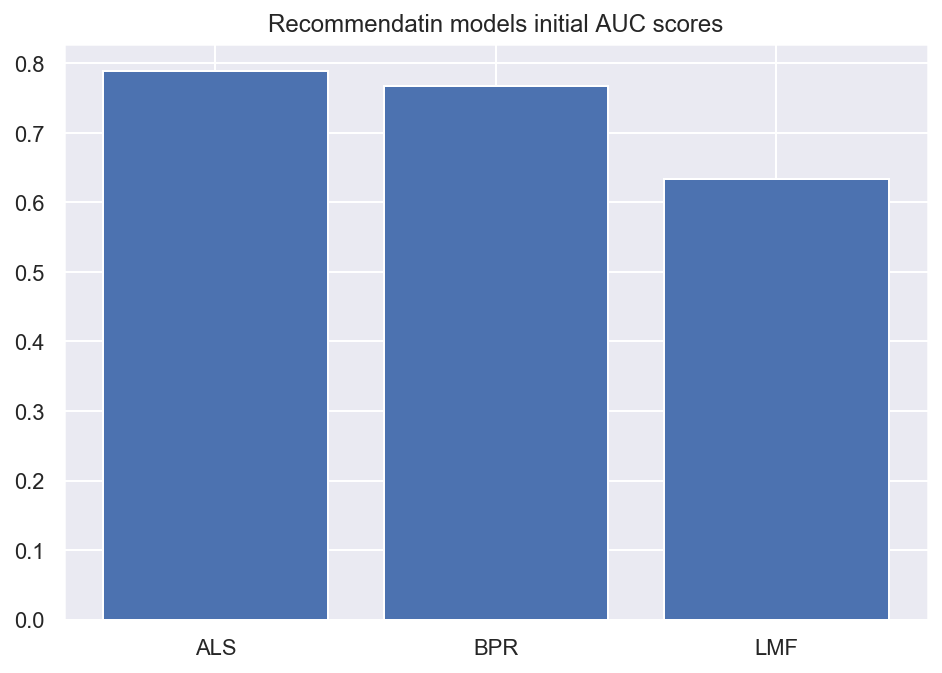

In [524]:
# Plot initial results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

als_score, pop_score  = calc_mean_auc(items_train, item_user_altered,[user_vecs_ALS, item_vecs_ALS.T], items_test)
pbr_score, pop_score  = calc_mean_auc(items_train, item_user_altered,[user_vecs_BPR, item_vecs_BPR.T], items_test)
lmf_score, pop_score = calc_mean_auc(items_train, item_user_altered,[user_vecs_LMF, item_vecs_LMF.T], items_test )


models_names = ['ALS', 'BPR', 'LMF']
models_scores = [als_score, pbr_score, lmf_score]
ax.bar(models_names,models_scores)
plt.title("Recommendation models initial AUC scores")
plt.show()

### Hyper-parameters tuning

In [113]:
# hyper-parameters tuning function
def tune_hp(recomendation_model, sparse_item_user_matrix):

    # define 
    best_score = 0
    best_params = {'alpha': 0, 'latent_factors': 0, 'regularizations': 0, 'iterations': 0}
    
    # define parameters grid
    alphas = [10, 15, 20, 25, 30, 40]
    latent_factors = [5, 10, 20, 30, 40, 50, 60]
    regularizations = [0.01, 0.05, 0.1, 0.5, 1.0, 1.5]
    iterations = [10, 20, 30, 40, 50, 60]
    
    # get training and validation sets
    items_train, items_test, item_user_altered = make_train(sparse_item_user_matrix, pct_test = 0.2)
    
    # interate over parameters
    for alpha in alphas:
        for factor in latent_factors:
            for regularization in regularizations:
                for iteration in iterations:

                    # create data to train the model
                    data = (items_train * alpha).astype('double')

                    # initialize model
                    model = recomendation_model(factors = factor, regularization = regularization, iterations = iteration)

                    # fit model
                    model.fit(data, show_progress = False)

                    # create vectors
                    user_vecs = sparse.csr_matrix(model.user_factors)
                    item_vecs = sparse.csr_matrix(model.item_factors)

                    # get score
                    score = calc_mean_auc(items_train, item_user_altered,[user_vecs, item_vecs.T], items_test)[0]

                    # update parameters if the score is higher
                    if score > best_score:
                        best_params['alpha'] = alpha
                        best_params['latent_factors'] = factor
                        best_params['regularizations'] = regularization
                        best_params['iterations'] = iteration
                        best_score = score
    
    # print results
    print("Best score:", score)
    message = "Best parameters: alpha: {}, factors: {}, regulation: {}, interactions: {}"
    print(message.format(best_params['alpha'], 
                         best_params['latent_factors'],
                         best_params['regularizations'],
                         best_params['iterations']))
    # return results   
    return score, best_params

As the cell above takes a long time to run, it will be kept as a markdown and the results displayed here. 

For the Alternating Least Squares model, the optimum results found are:
- Best score: 0.82
- Best parameters: alpha: 15, factors: 50, regulation: 0.1, interactions: 50

As the cell above takes a long time to run, it will be kept as a markdown and the results displayed here.

For the Logistic Matrix Factorization, the optimum results found are:

Best score: 0.77
Best parameters: alpha: 30, factors: 10, regulation: 0.05, interactions: 20

As the cell above takes a long time to run, it will be kept as a markdown and the results displayed here.

For the LBayesian Personalized Ranking, the optimum results found are:

Best score: 0.64
Best parameters: alpha: 15, factors: 40, regulation: 0.01, interactions: 60

In [305]:
# Train model with the optmium parameters

# get training and validation sets
items_train, items_test, item_user_altered = make_train(sparse_item_user, pct_test = 0.2)

# Initialize the Alternating Least Squares (ALS) model with initial parameters
model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50)

# Fit the model using the training sparse content-person matrix
alpha = 15
data = (items_train * alpha).astype('double')
model.fit(data)

### Find similar items

In [335]:
# Pick a product and find its most similar products and compare their descriptions 

# Encoded Stock code of a product (randomly selected) 
item_id = 2706

# Number of similiar products to find (the number - 1)
n_similar = 11

# Get the customer and item vectors from trained model
user_vecs = model.user_factors
item_vecs = model.item_factors

# Calculate the vector norms
item_norms = np.sqrt((item_vecs * item_vecs).sum(axis=1))

# Calculate the similarity score
scores = item_vecs.dot(item_vecs[item_id]) /item_norms

# Get the top 10 most similar items
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]

# Create a list of content-score tuples of most similar items
similar = sorted(zip(top_idx, scores[top_idx] / item_norms[item_id]), key=lambda x: -x[1])

In [336]:
# Get product stockcode
item_stock_code = grouped_df[grouped_df['Stock_Code'] == item_id]['StockCode'].unique()[0]

# Get product description
item_description = df1[df1['StockCode'] == item_stock_code]['Description'].unique().tolist()

# Print product description
print("Most similar products to: ", item_description[0], ":\n")

for item in similar[1:]:
    idx, score = item
    
    # Get stock code of the similiar products
    stock_code = grouped_df['StockCode'].loc[grouped_df['Stock_Code'] == idx].iloc[0]
    
    # Get products descriptions 
    similar_products =df1[df1['StockCode']==stock_code]['Description'].unique().tolist()[0]
    
    print(similar_products)

Most similar products to:  PACK/12 XMAS FUN CARD :

SET 10 CARDS PERFECT POST 17090
SET 10 CARDS DRESSING UP 17077
PINK GLASS CHUNKY CHARM BRACELET
SET 10 CARDS CHRISTMAS TREE 16955
SET 10 CARDS OUT OF ORDER 17216
SET 10 CARDS SCOTTIE DOG 17211
PAINTED METAL HEART WITH HOLLY BELL
SET 10 CARDS XMAS CHOIR 17068
SET 10 CARD CHRISTMAS WELCOME 17112
BLUE TILED TRAY


It is possible to see that the recommended similar products are very related to the original product.

### Recommend items to customers

In [337]:
# Create function return the top recommendations based on the customer/item vectors
# for items never interacted with before for any given person

def recommend(user_id, sparse_user_item, user_vecs, item_vecs, num_items=10):
    
    # Get the interactions scores from the sparse user item matrix
    user_interactions = sparse_user_item[user_id, :].toarray()
    
    # Add 1 to everything, so that items with no interaction yet become equal to 1
    user_interactions = user_interactions.reshape(-1) + 1
    
    # Make items already interacted zero
    user_interactions[user_interactions > 1] = 0
    
    # Get dot product of user vector and all item vectors
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T).toarray()
    
    # Scale the recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    
    # Items already interacted have their recommendation multiplied by zero
    recommend_vector = user_interactions * rec_vector_scaled
    
    # Sort the indices of the item into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1][:num_items]
    
    # Start empty list to store item descriptions and scores
    descriptions = []
    scores = []
    
    # Append descriptions and scores to the list
    for idx in content_idx:
        # get stock code of the the product
        stock_code = grouped_df['StockCode'].loc[grouped_df['Stock_Code'] == idx].iloc[0]

        # get products descriptions
        item_description = df1[df1['StockCode']==stock_code]['Description'].unique().tolist()[0]

        descriptions.append(item_description)
        scores.append(recommend_vector[idx])
    
    # Create dataframe with the resulting data
    recommendations = pd.DataFrame({'Descriptions': descriptions, 'score': scores})
    
    return recommendations

In [357]:
# Get the trained user and item vectors. Convert them to csr matrices
user_vecs = sparse.csr_matrix(model.user_factors)
item_vecs = sparse.csr_matrix(model.item_factors)

# Create recommendations for customer with encoded id = 1838 (randomly chosen)
user_id = 1993

# Make recomendations
recommendations = recommend(user_id, sparse_user_item, user_vecs, item_vecs)

# Print recomendations
print(recommendations)

                      Descriptions     score
0  GLASS APOTHECARY BOTTLE PERFUME  0.978019
1   GLASS APOTHECARY BOTTLE ELIXIR  0.925436
2    HOME SWEET HOME HANGING HEART  0.841658
3         LAVENDER TOILETTE BOTTLE  0.802857
4         PAPER BUNTING WHITE LACE  0.802591
5                REGENCY CAKE FORK  0.799073
6               GLASS CLOCHE SMALL  0.797617
7      ANTIQUE GLASS PEDESTAL BOWL  0.787130
8     LARGE PINK GLASS SUNDAE DISH  0.776100
9   HOME SWEET HOME CUSHION COVER   0.774185


In [358]:
# Check recommendations by comparing them to the 10 items this user has most interacted  with
most_bought_items = grouped_df[grouped_df['Customer_ID'] == user_id].sort_values(by=['Quantity'], ascending=False).head(10)

# Get item descriptions based on its StockCode
description_list = []
for index, row in most_bought_items.iterrows():
    code = str(row['StockCode'])
    description_list.append(df1[df1['StockCode'] == code]['Description'].unique()[0])

# Add item descriptions to the dataframe and filter relevant columns
most_bought_items['Description'] = description_list
most_bought_items = most_bought_items[['Description', 'Quantity']]
                     
# Show the 10 items this user has most interacted  with
most_bought_items

,Description,Quantity
132550,GLASS APOTHECARY BOTTLE TONIC,12.0
132551,GLASS TWIST BON BON JAR,12.0
132549,GLASS BEURRE DISH,8.0
132552,GLASS SONGBIRD STORAGE JAR,8.0
132553,SET OF 16 VINTAGE ROSE CUTLERY,1.0
132554,SET OF 16 VINTAGE PISTACHIO CUTLERY,1.0
132555,SET OF 16 VINTAGE RED CUTLERY,1.0
132556,SET OF 16 VINTAGE BLACK CUTLERY,1.0
132557,SET OF 16 VINTAGE SKY BLUE CUTLERY,1.0


As it is possible to notice, the most purchased products from this user and the recommended products have very related descriptions.

### New customers

As new users do not yet have interactions for the recommendation system to know their personal preferences, and as the only data available in the dataset about users is for their countries, first-time customers will be recommended the products that are currently the most sold in their regions.

In [493]:
# function to recommend the top 10 most recently sold products for a given country whithin a given number of last months
def recomendations_new_users(country, months):
    
    # filter for the entered country
    new_users_rec_df = df1[df1['Country'] == country]
    
    # get initial month
    initial_month = pd.Series(df1['Month_Year'].unique()).sort_values(ascending=False).iloc[months]
    
    # filter for recent purchases
    new_users_rec_df = new_users_rec_df[new_users_rec_df['Month_Year'] > initial_month]
    
    # select most sold products
    recommended_products_codes = new_users_rec_df.groupby(['StockCode'])['Quantity'].sum().sort_values(ascending=False)
    recommended_products_codes = recommended_products_codes.head(10).index.tolist()

    # initialize empty list
    recommended_products_names = []
    
    # get the names of the recommended products
    for stock_code in recommended_products_codes:
        
        product_description = new_users_rec_df[new_users_rec_df['StockCode'] == stock_code]['Description'].unique()[0]
        recommended_products_names.append(product_description)
        
    return recommended_products_names

In [507]:
# Recommend products to a new customer from United Kingdom based on the most sold products from the last 2 months
recomendations_new_users('United Kingdom', 2)

['POPCORN HOLDER',
 'RABBIT NIGHT LIGHT',
 "PAPER CHAIN KIT 50'S CHRISTMAS ",
 'JUMBO BAG RED RETROSPOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'WOODEN STAR CHRISTMAS SCANDINAVIAN',
 'DISCO BALL CHRISTMAS DECORATION',
 'WORLD WAR 2 GLIDERS ASSTD DESIGNS',
 'WOODEN HEART CHRISTMAS SCANDINAVIAN',
 'WHITE HANGING HEART T-LIGHT HOLDER']

Most of the recommended products are Christmas items, since the purchases made in the last two months of the dataframe are close to Christmas. 